In [2]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    cv2.imshow("Image Collection",frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[60:60+350,200:200+350, :])

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[60:60+350,200:200+350, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path q
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefulcv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [6]:
#Pipelining
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)


In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
print(dir_test.next())

b'data\\anchor\\89b699d8-efdf-11ed-a61f-dc215cabee6e.jpg'


In [9]:
def preprocess(file_path):
     # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [10]:
img =preprocess('data\\anchor\\b8627f7e-efe3-11ed-8382-dc215cabee6e.jpg'
)

In [11]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.9882353 , 0.98039216, 0.99215686],
        [0.9882353 , 0.98039216, 0.99215686],
        [0.99607843, 0.9764706 , 0.99215686],
        ...,
        [0.63235295, 0.577451  , 0.53431374],
        [0.6252451 , 0.57034314, 0.5272059 ],
        [0.62916666, 0.5742647 , 0.53112745]],

       [[0.9882353 , 0.98039216, 0.9843137 ],
        [0.9882353 , 0.98039216, 0.9843137 ],
        [0.99607843, 0.98039216, 0.9843137 ],
        ...,
        [0.6480392 , 0.59313726, 0.55      ],
        [0.6453431 , 0.59044117, 0.5473039 ],
        [0.64509803, 0.5901961 , 0.5470588 ]],

       [[0.9882353 , 0.98039216, 0.9843137 ],
        [0.9882353 , 0.98039216, 0.9843137 ],
        [0.9882353 , 0.98039216, 0.9843137 ],
        ...,
        [0.6598039 , 0.60490197, 0.5617647 ],
        [0.65367645, 0.60269606, 0.56740195],
        [0.654902  , 0.6039216 , 0.5686275 ]],

       ...,

       [[0.5372549 , 0.2254902 , 0.3480392 ],
        [0.47

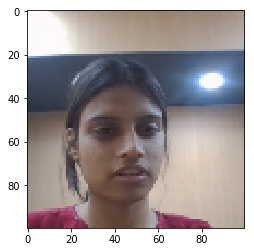

In [12]:
plt.imshow(img)

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)



In [14]:
samples = data.as_numpy_iterator()

In [15]:
exampple=samples.next()

In [16]:
def preprocessDataset(img,val_img,label):
    return (preprocess(img),preprocess(val_img),label)

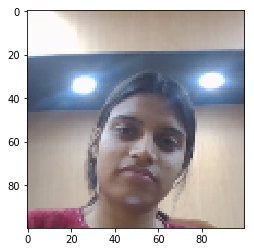

In [17]:
res = preprocessDataset(*exampple)
plt.imshow(res[1])

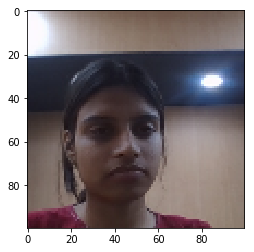

In [18]:
plt.imshow(res[0])

In [19]:
# Build dataloader pipeline
data = data.map(preprocessDataset)
data = data.cache()
data = data.shuffle(buffer_size=1024)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [20]:
#Creating Model

def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [21]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [22]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [23]:
l1 = L1Dist()
l1

In [24]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [25]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [26]:
siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [27]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [28]:
opt = tf.keras.optimizers.Adam(1e-4) # learning rate is 1e-4

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [30]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [31]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [32]:
EPOCHS = 40
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 411s 15s/step

 Epoch 2/40
27/27 [==============================] - 474s 18s/step

 Epoch 3/40
27/27 [==============================] - 540s 20s/step

 Epoch 4/40
27/27 [==============================] - 423s 16s/step

 Epoch 5/40
27/27 [==============================] - 1062s 40s/step

 Epoch 6/40
27/27 [==============================] - 390s 14s/step

 Epoch 7/40
27/27 [==============================] - 1953s 75s/step

 Epoch 8/40
27/27 [==============================] - 392s 15s/step

 Epoch 9/40
27/27 [==============================] - 1755s 67s/step

 Epoch 10/40
27/27 [==============================] - 385s 14s/step

 Epoch 11/40
27/27 [==============================] - 644s 24s/step

 Epoch 12/40
27/27 [==============================] - 395s 15s/step

 Epoch 13/40
27/27 [===

In [42]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [53]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [54]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[9.9999273e-01],
       [8.7439146e-11],
       [8.7698110e-13],
       [1.0000000e+00],
       [2.7949590e-10],
       [2.9916439e-06],
       [2.5525953e-12],
       [3.4251851e-11],
       [9.9989188e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.2361905e-06],
       [1.0000000e+00],
       [7.7704323e-07],
       [7.0919555e-12],
       [1.0000000e+00]], dtype=float32)

In [55]:
y_hat =[1 if prediction > 0.5 else 0 for prediction in y_hat ]
y_hat

[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]

In [56]:
y_true

array([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [57]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [58]:
# Creating a metric object 
m = Accuracy()

# Calculating the ACCURACY value 
m.update_state(y_true, y_hat)

# Return ACCURACY Result
m.result().numpy()

1.0

In [60]:
# Creating a metric object 
m = Precision()

# Calculating the PRECISION value 
m.update_state(y_true, y_hat)

# Return PRECISION Result
m.result().numpy()

1.0

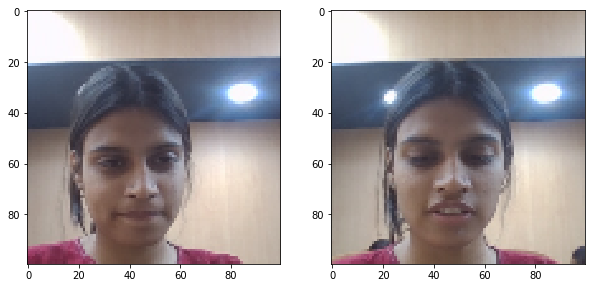

In [59]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [ ]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [61]:
os.listdir(os.path.join('Application_data', 'Verification_data'))

['01b1e39c-efe4-11ed-beaa-dc215cabee6e.jpg',
 '01d8e706-efe4-11ed-a3f4-dc215cabee6e.jpg',
 '02afb1e8-efe4-11ed-92bb-dc215cabee6e.jpg',
 '037cb924-efe4-11ed-9a4c-dc215cabee6e.jpg',
 '046ec2d8-efe4-11ed-8ace-dc215cabee6e.jpg',
 '04d75b62-efe4-11ed-9f8d-dc215cabee6e.jpg',
 '06a4d91c-efe4-11ed-b3a0-dc215cabee6e.jpg',
 '09b6fe34-efe4-11ed-989b-dc215cabee6e.jpg',
 '0a26a2c2-efe4-11ed-a1ab-dc215cabee6e.jpg',
 '0a49f988-efe4-11ed-9782-dc215cabee6e.jpg',
 '0af975a8-efe4-11ed-884d-dc215cabee6e.jpg',
 '0b3bac38-efe4-11ed-9e85-dc215cabee6e.jpg',
 '0b5def06-efe4-11ed-b2a7-dc215cabee6e.jpg',
 '0b7f9cb4-efe4-11ed-942e-dc215cabee6e.jpg',
 '0c90d474-efe4-11ed-b77f-dc215cabee6e.jpg',
 '0cb5a258-efe4-11ed-b7db-dc215cabee6e.jpg',
 '0e23d3e4-efe4-11ed-8b8a-dc215cabee6e.jpg',
 '0ec59998-efe4-11ed-83fa-dc215cabee6e.jpg',
 '0ee70ea4-efe4-11ed-a5d0-dc215cabee6e.jpg',
 '0f527d0c-efe4-11ed-b379-dc215cabee6e.jpg',
 '0f9e32e4-efe4-11ed-a2e6-dc215cabee6e.jpg',
 '0fc30702-efe4-11ed-9004-dc215cabee6e.jpg',
 '14a86d1e

In [62]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('Application_data', 'Verification_data')):
        input_img = preprocess(os.path.join('Application_data', 'Input_data', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('Application_data', 'Verification_data', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('Application_data', 'Verification_data'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[60:60+350,200:200+350, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('Application_data', 'Input_data', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results)>0.5)


In [ ]:
!pip install tensorflow 

In [ ]:
!python.exe -m pip install --upgrade pip 

In [ ]:
!conda install tensorflow-gpu==2.4.1

In [ ]:
!conda install -c anaconda tensorflow-gpu